# **DATA CLEANING**

## IMPORTS

In [37]:
# Imports
import numpy as np
import pandas as pd
import statistics
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## LOADING

In [29]:
# We load the data and check the first rows
data = pd.read_csv('../data/raw/idealista_viviendas_detalle.csv', )

# We change the names of the columns to make them easier to english and to avoid special characters
data.columns = ["url", "price", "zone","neighborhood", "built_area", "usable_area", "bedrooms", "bathrooms", "floor", "exterior", "elevator", "garage", "storage_room", "balcony", "new", "condition", "year", "heating", "agency", "consumption_value", "consumption_label", "emissions_value", "emissions_label", "description", "error"]
data.head()

,url,price,zone,neighborhood,built_area,usable_area,bedrooms,bathrooms,floor,exterior,...,condition,year,heating,agency,consumption_value,consumption_label,emissions_value,emissions_label,description,error
0,https://www.idealista.com/inmueble/109356873/,440.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",76.0,70.0,2.0,2.0,3.0,exterior,...,Buen estado,2025.0,Individual,ORDUNTE Inmobiliaria,23,A,4,A,"GASTOS DE GESTIÓN de 1,5 por ciento + IVA a ca...",NaN
1,https://www.idealista.com/inmueble/106221410/,442.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",82.0,NaN,2.0,2.0,1.0,exterior,...,NaN,NaN,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...,NaN
2,https://www.idealista.com/inmueble/107750109/,381.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",58.0,NaN,1.0,1.0,4.0,exterior,...,NaN,NaN,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...,NaN
3,https://www.idealista.com/inmueble/106221526/,575.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",104.0,NaN,3.0,2.0,1.0,exterior,...,NaN,NaN,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...,NaN
4,https://www.idealista.com/inmueble/108491309/,306.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",62.0,NaN,1.0,1.0,1.0,exterior,...,NaN,NaN,NaN,Loiola,NaN,A,NaN,A,"60 viviendas de obra nueva de 1, 2 y 3 habitac...",NaN


## CLEANING

In [30]:
# We check the summarize information of the dataset, to see the types of the columns and if there are null values
data.info()

# We remove the column that we will not use
data = data.drop(columns=["error"]) # Url is not useful for our analysis, but we will keep it for now in case we want to check some house manually

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                1490 non-null   object 
 1   price              1417 non-null   object 
 2   zone               1490 non-null   object 
 3   neighborhood       1417 non-null   object 
 4   built_area         1417 non-null   float64
 5   usable_area        968 non-null    float64
 6   bedrooms           1407 non-null   float64
 7   bathrooms          1415 non-null   float64
 8   floor              1271 non-null   float64
 9   exterior           1249 non-null   object 
 10  elevator           1392 non-null   object 
 11  garage             371 non-null    object 
 12  storage_room       381 non-null    object 
 13  balcony            780 non-null    object 
 14  new                1407 non-null   object 
 15  condition          1286 non-null   object 
 16  year               759 n

In [31]:
# We check the rows that contain all null values (except the zona column, which is the only one that has no null values)
null_columns = data[data.drop(columns=["zone", "url"]).isnull().all(axis=1)]
# The rows that contain all null values are the houses that have been removed from the website, probably because they 
# have been sold in just a day (the time between getting the url of the houses and getting the detailed information). 

# We get how many houses have been sold in one day per zone, just out of curiosity
print(null_columns['zone'].value_counts())

# As there are more houses in a zone than in others, we get the percentage of houses that have been sold in one day per zone
print((null_columns['zone'].value_counts() / data['zone'].value_counts()).sort_values(ascending=False))
# In some zones, more than 10% of the houses have been sold in one day.

# We drop these rows, as they do not provide any useful information
data = data.dropna(how='all', subset=data.columns.difference(['zone', "url"]))

zone
abando-albia             23
begona-santutxu          10
uribarri                  9
indautxu                  9
rekalde                   6
basurto-zorroza           5
ibaiondo                  5
casco-viejo               3
deusto                    2
otxarkoaga-txurdinaga     1
Name: count, dtype: int64
zone
begona-santutxu          0.113636
abando-albia             0.082143
uribarri                 0.066176
indautxu                 0.053892
casco-viejo              0.046154
basurto-zorroza          0.033113
rekalde                  0.028037
otxarkoaga-txurdinaga    0.027778
ibaiondo                 0.023585
deusto                   0.020619
san-adrian-la-pena            NaN
Name: count, dtype: float64


In [32]:
# We check again the summarize information of the dataset
data.info()

# We check the percentage of null values per column
null_percentage = data.isnull().mean().sort_values(ascending=False)
print(null_percentage)

# We will tranform some columns to make them easier to use, changing their format, data type and filling null values.
# Let's go column by column:

#? Price: we will change the thousands separator and convert it to a numeric value (no null values)
data['price'] = data['price'].str.replace('.', '', regex=False).astype(float)

#? Zone and neighborhood: will transform them to categorical variables (no null values)
data['zone'] = data['zone'].astype('category')
data['neighborhood'] = data['neighborhood'].astype('category')

#? Built area: we will leave it as is, since there data type is correct (no null values)

#? Usable area: we will not do anything for now (null values: 32%)

#? Bedrooms: as there are just 10 null values, we will check them manually
data[data['bedrooms'].isnull()]["url"]
# All of them are studios where people can not live, so we do not take them into account and we will drop them
data = data.dropna(subset=['bedrooms'])
# We convert it to an integer. Finally (no null values)
data['bedrooms'] = data['bedrooms'].astype(int) 

# As we have drop some rows, we check the percentage and number of null values per column again
null_amount = data.isnull().sum().sort_values(ascending=False)
print(null_percentage, null_amount)

#? Bathrooms: will transform them to integer variables (no null values)
data['bathrooms'] = data['bathrooms'].astype(int)

#? Floor:

#? Exterior: binary column (exterior/interior)

#? Elevator, garage, storage_room, balcony: we will transform these columns into binary ones and fill the null values with False, 
#? as it means that the house does not have these features
for col in ['garage', 'storage_room', 'balcony', 'elevator']:
    data[col] = data[col].notnull()
    data[col] = data[col].fillna(False)

#? New: there are just two possible values: "Obra nueva" and "Segunda Mano", so we will transform this column into a binary one
# Also, the new column, as there are just 10 null values, we will check them manually and fill them with the correct value
print(data[data['new'].isnull()]["url"])
data['new'] = data['new'].map({"Obra nueva": True, "Segunda mano": False})


# After checking the urls, we see that all the houses are new, so we fill the null values with True
data['new'] = data['new'].fillna(True)


# Print the value counts of the new column to check that there are no null values
print(data['new'].value_counts())

#? Condition

#? Year: as there are many null values (45%), we will not do anything for now

#? Heating:

#? Agency: in the case of null values, it means that the house is being sold by the owner, so we will fill the null values with "owner"
data['agency'] = data['agency'].fillna("owner")
data['agency'] = data['agency'].astype('category')

#? Consumption value and label:

#? Emisions value and label:

#? Description: in the case of null values, it means that there is no description, so we will fill the null values with an empty string
data['description'] = data['description'].fillna("")


print(data.info())

# We check the percentage of null values per column
null_percentage = data.isnull().mean().sort_values(ascending=False)
print(null_percentage)

<class 'pandas.core.frame.DataFrame'>
Index: 1417 entries, 0 to 1489
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                1417 non-null   object 
 1   price              1417 non-null   object 
 2   zone               1417 non-null   object 
 3   neighborhood       1417 non-null   object 
 4   built_area         1417 non-null   float64
 5   usable_area        968 non-null    float64
 6   bedrooms           1407 non-null   float64
 7   bathrooms          1415 non-null   float64
 8   floor              1271 non-null   float64
 9   exterior           1249 non-null   object 
 10  elevator           1392 non-null   object 
 11  garage             371 non-null    object 
 12  storage_room       381 non-null    object 
 13  balcony            780 non-null    object 
 14  new                1407 non-null   object 
 15  condition          1286 non-null   object 
 16  year               759 non-nu

C:\Users\enetz\AppData\Local\Temp\ipykernel_8060\2201531428.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['new'] = data['new'].fillna(True)


### Usable Area Cleaning

Using the mean to approximate per zone

In [44]:
data_mod_ua_mean = data.copy()

# Loop through each unique zone value in the 'zone' column
for zone_ua in data_mod_ua_mean['zone'].unique():
    
    # Create a boolean mask to select only the rows belonging to the current zone
    mask = data_mod_ua_mean['zone'] == zone_ua
    
    # Check if there are any rows in this zone (Safety Check)
    if mask.any():
        
        # Calculate the mean 'built_area' & 'usable_area' for the current zone and the percentage decrease between them
        ba_mean = data_mod_ua_mean.loc[mask, 'built_area'].mean()
        ua_mean = data_mod_ua_mean.loc[mask, 'usable_area'].mean()
        pda_mean = ((ba_mean - ua_mean) / ba_mean) * 100
        print(f"Zone: {zone_ua}, Mean Built Area: {ba_mean}, Mean Usable Area: {ua_mean}, Mean Percentage Decrease Area: {pda_mean}")
        
        # Replace missing 'usable_area' values in this zone with estimated values based on the mean percentage decrease
        data_mod_ua_mean.loc[mask & data_mod_ua_mean['usable_area'].isnull(), 'usable_area'] = data_mod_ua_mean.loc[mask & data_mod_ua_mean['usable_area'].isnull(), 'built_area'] * (1 - pda_mean)


print(data_mod_ua_mean.info())

Zone: deusto, Mean Built Area: 111.02105263157895, Mean Usable Area: 95.71428571428571, Mean Percentage Decrease Area: 13.787265166804383
Zone: uribarri, Mean Built Area: 121.51587301587301, Mean Usable Area: 105.18072289156626, Mean Percentage Decrease Area: 13.442811806300375
Zone: otxarkoaga-txurdinaga, Mean Built Area: 101.74285714285715, Mean Usable Area: 78.44, Mean Percentage Decrease Area: 22.90367874192643
Zone: basurto-zorroza, Mean Built Area: 97.8972602739726, Mean Usable Area: 93.3010752688172, Mean Percentage Decrease Area: 4.694906672865662
Zone: abando-albia, Mean Built Area: 150.8078431372549, Mean Usable Area: 139.9022988505747, Mean Percentage Decrease Area: 7.2314171861437755
Zone: indautxu, Mean Built Area: 134.8987341772152, Mean Usable Area: 126.14414414414415, Mean Percentage Decrease Area: 6.489749578799035
Zone: casco-viejo, Mean Built Area: 114.55737704918033, Mean Usable Area: 96.91891891891892, Mean Percentage Decrease Area: 15.39705131576912
Zone: begona-s

Using the linear reggression to approximate per zone

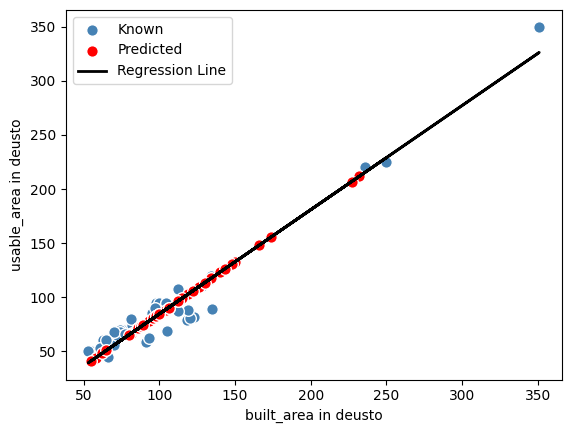

Predicted Values Result
Zone: deusto, Mean Built Area: 110.47826086956522, Mean Usable Area: 94.70106496657391, Mean Percentage Decrease Area: 14.280814866934282


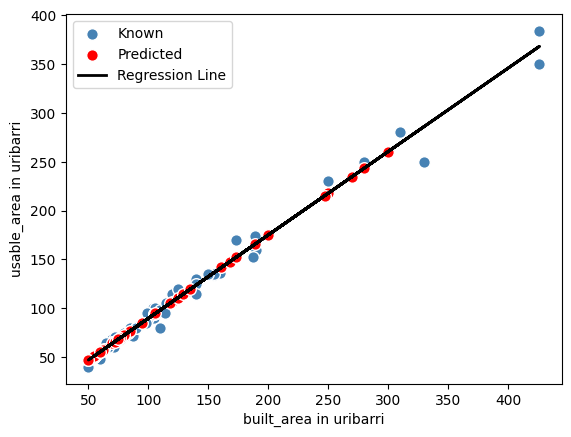

Predicted Values Result
Zone: uribarri, Mean Built Area: 127.79069767441861, Mean Usable Area: 113.31377126974549, Mean Percentage Decrease Area: 11.328623028224644


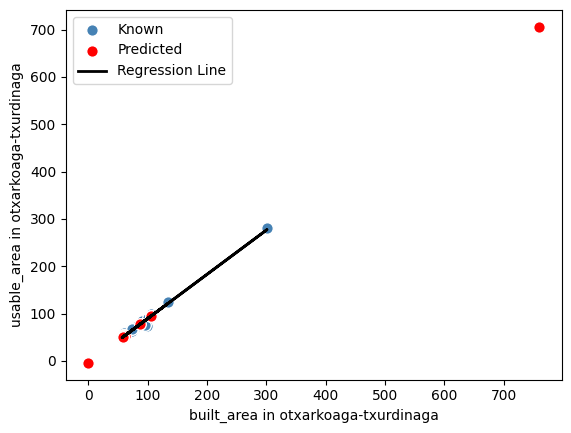

Predicted Values Result
Zone: otxarkoaga-txurdinaga, Mean Built Area: 135.7, Mean Usable Area: 122.84761614560409, Mean Percentage Decrease Area: 9.471174542664626


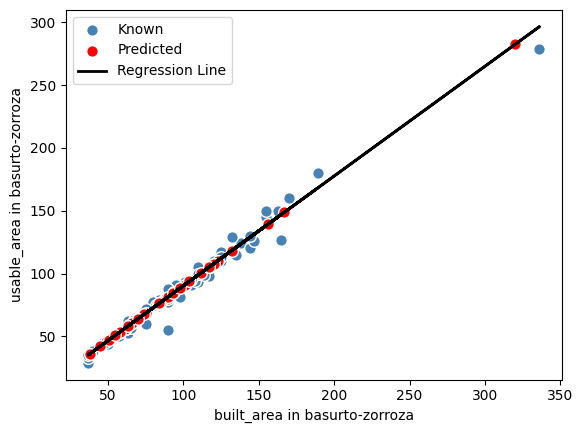

Predicted Values Result
Zone: basurto-zorroza, Mean Built Area: 88.13207547169812, Mean Usable Area: 79.91571148830943, Mean Percentage Decrease Area: 9.322785080702216


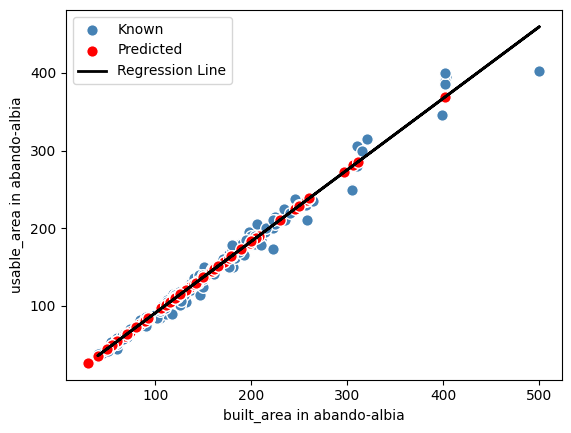

Predicted Values Result
Zone: abando-albia, Mean Built Area: 146.39506172839506, Mean Usable Area: 133.95450682009061, Mean Percentage Decrease Area: 8.497933442171195


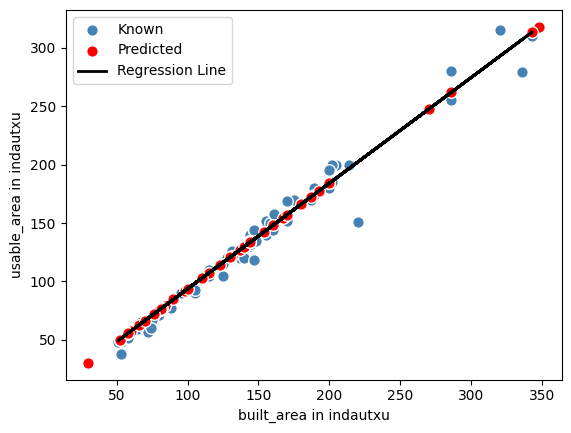

Predicted Values Result
Zone: indautxu, Mean Built Area: 132.61702127659575, Mean Usable Area: 123.20670838639715, Mean Percentage Decrease Area: 7.095856021808664


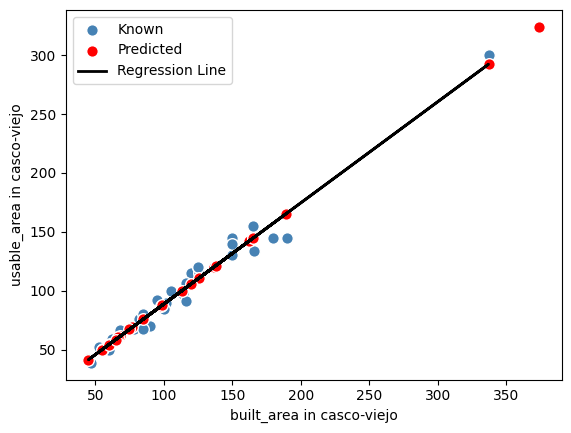

Predicted Values Result
Zone: casco-viejo, Mean Built Area: 122.375, Mean Usable Area: 107.98174889641471, Mean Percentage Decrease Area: 11.761594364523216


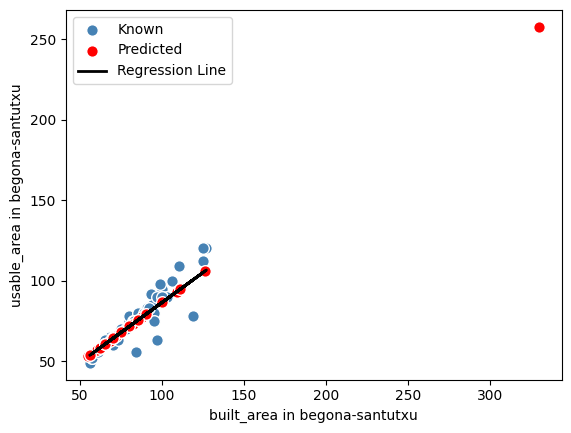

Predicted Values Result
Zone: begona-santutxu, Mean Built Area: 87.6, Mean Usable Area: 77.25689221145778, Mean Percentage Decrease Area: 11.807200671851842


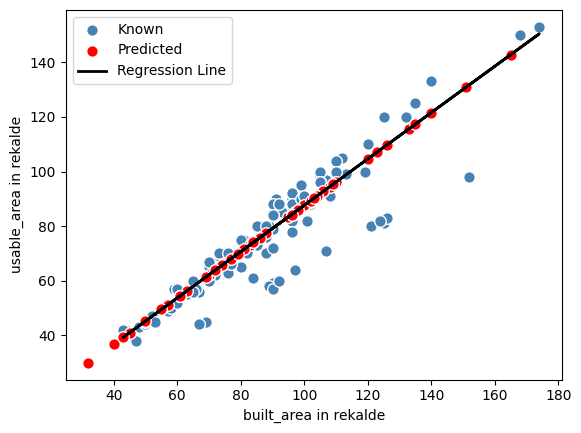

Predicted Values Result
Zone: rekalde, Mean Built Area: 89.85185185185185, Mean Usable Area: 79.03016673041232, Mean Percentage Decrease Area: 12.043919962030804


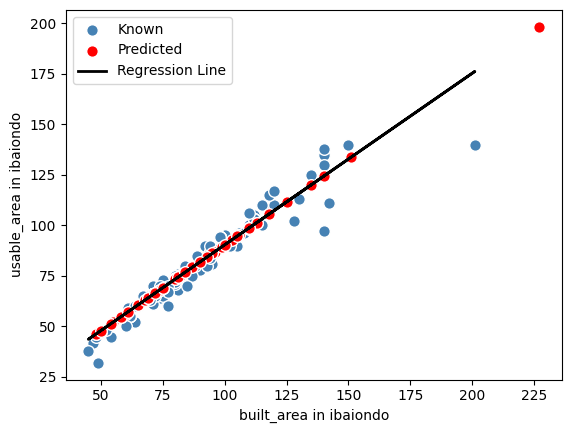

Predicted Values Result
Zone: ibaiondo, Mean Built Area: 91.14814814814815, Mean Usable Area: 82.82108974941372, Mean Percentage Decrease Area: 9.135740624373415


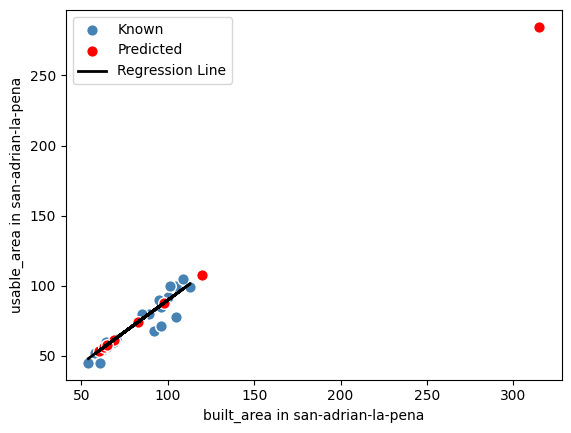

Predicted Values Result
Zone: san-adrian-la-pena, Mean Built Area: 109.125, Mean Usable Area: 97.98908582603426, Mean Percentage Decrease Area: 10.204732347276742


In [53]:
data_mod_ua_lr = data.copy()

# Loop through each unique zone
for zone_ua in data_mod_ua_lr['zone'].unique():
    
    # Select rows belonging to the current zone
    mask = data_mod_ua_lr['zone'] == zone_ua
    zone_data = data_mod_ua_lr.loc[mask]

    # Separate rows with and without usable_area values
    known = zone_data[zone_data['usable_area'].notnull()]
    unknown = zone_data[zone_data['usable_area'].isnull()]

    # Prepare data for regression
    X_train = known[['built_area']].values
    y_train = known['usable_area'].values

    # Train the linear regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # Predict usable_area for rows where it's missing
    X_pred = unknown[['built_area']].values
    predicted_values = lin_reg.predict(X_pred)

    # Calculate the mean 'built_area' & 'usable_area' for the current zone and the percentage decrease between them for the newly predicted values
    mask_unknown = (data_mod_ua_lr['zone'] == zone_ua) & (data_mod_ua_lr['usable_area'].isnull())
    ba_mean = data_mod_ua_lr.loc[mask_unknown, 'built_area'].mean()
    ua_mean = predicted_values.mean()
    pda_mean = ((ba_mean - ua_mean) / ba_mean) * 100

    # Fill missing usable_area with predictions
    data_mod_ua_lr.loc[unknown.index, 'usable_area'] = predicted_values

    # Visualize the results
    plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, label='Known')
    plt.scatter(X_pred, predicted_values, c='red', edgecolor='white', s=70, label='Predicted')
    plt.plot(X_train, lin_reg.predict(X_train), color='black', lw=2, label='Regression Line')
    plt.xlabel('built_area in ' + zone_ua)
    plt.ylabel('usable_area in ' + zone_ua)
    plt.legend()
    plt.show()

    print(f"Predicted Values Result\nZone: {zone_ua}, Mean Built Area: {ba_mean}, Mean Usable Area: {ua_mean}, Mean Percentage Decrease Area: {pda_mean}")

### IDK

In [278]:
# Check the amount of houses with exterior orientation
print(data['exterior'].value_counts())

# Print the urls of the houses with null orientation
print(data[data['exterior'].isnull()]["url"])

print(data[data["new"] == True]["exterior"].isnull().sum())


exterior
exterior    1061
interior     183
Name: count, dtype: int64
10      https://www.idealista.com/inmueble/108574469/
14      https://www.idealista.com/inmueble/104105241/
15      https://www.idealista.com/inmueble/108376976/
16      https://www.idealista.com/inmueble/106596850/
24      https://www.idealista.com/inmueble/109237730/
28      https://www.idealista.com/inmueble/108746339/
36      https://www.idealista.com/inmueble/107151456/
37      https://www.idealista.com/inmueble/104175500/
38      https://www.idealista.com/inmueble/106596877/
39      https://www.idealista.com/inmueble/107151440/
56      https://www.idealista.com/inmueble/109337060/
59      https://www.idealista.com/inmueble/108748919/
60      https://www.idealista.com/inmueble/108748921/
66      https://www.idealista.com/inmueble/106517920/
76      https://www.idealista.com/inmueble/108396564/
82      https://www.idealista.com/inmueble/107910726/
83      https://www.idealista.com/inmueble/108520857/
84      https

In [279]:
# Check the amount of houses per condition
print(data['condition'].value_counts())

condition
Buen estado    967
A reformar     309
Name: count, dtype: int64


In [280]:
# Check the amount of heating 
print(data['heating'].value_counts())

# Check the amount of houses with missing value in year, and compare each case with the value of the "new" column. We want to see how many of them have "new" as True
heating_data = data[data['heating'].notnull()][['heating', 'new']]

# We check how many of them have "new" as True
print(heating_data['new'].value_counts())

data[data["new"] == True]["heating"].value_counts()


heating
Individual    763
Central       242
Name: count, dtype: int64
new
False    968
True      37
Name: count, dtype: int64


heating
Individual    26
Central       11
Name: count, dtype: int64

In [281]:
# Check the amount of houses with missing value in year, and compare each case with the value of the "new" column. We want to see how many of them have "new" as True
year_data = data[data['year'].isnull()][['year', 'new']]

# We check how many of them have "new" as True
print(year_data['new'].value_counts())

# Print the new column
print(data['new'].value_counts())

new
False    518
True     131
Name: count, dtype: int64
new
False    1276
True      131
Name: count, dtype: int64


"CONDITION" CLEANING

In [282]:
print(data.shape)
print("Numero Condition null: ", data['condition'].isnull().sum())


#Los 131 casos en los que "condition" es null porque la casa es NUEVA:
print("Numero Condition null y New True: ", data[(data['condition'].isnull()) & (data['new'] == True)].shape[0])

#Voy a confirmarlo a mano: 
print(data[data['condition'].isnull()]['url'])
#Efectivamente todas los valores de "condition" que son null, son casas nuevas. 

# Por lo que voy a rellenar esos 131 valores con de la columna "condition" con "Nuevo"
data.loc[data['condition'].isnull(), 'condition'] = 'Nuevo'


print(data.head())

(1407, 24)
Numero Condition null:  131
Numero Condition null y New True:  131
1       https://www.idealista.com/inmueble/106221410/
2       https://www.idealista.com/inmueble/107750109/
3       https://www.idealista.com/inmueble/106221526/
4       https://www.idealista.com/inmueble/108491309/
5       https://www.idealista.com/inmueble/108491397/
6       https://www.idealista.com/inmueble/108491389/
14      https://www.idealista.com/inmueble/104105241/
15      https://www.idealista.com/inmueble/108376976/
16      https://www.idealista.com/inmueble/106596850/
29      https://www.idealista.com/inmueble/106993005/
30      https://www.idealista.com/inmueble/106993032/
31      https://www.idealista.com/inmueble/106993141/
32      https://www.idealista.com/inmueble/106993139/
33      https://www.idealista.com/inmueble/106993140/
34      https://www.idealista.com/inmueble/106993143/
35      https://www.idealista.com/inmueble/106993138/
36      https://www.idealista.com/inmueble/107151456/
37  

"YEAR" CLEANING

In [283]:
null_percentage = data.isnull().mean().sort_values(ascending=False)
print(null_percentage)

emissions_value      0.490405
consumption_value    0.487562
year                 0.461265
emissions_label      0.345416
consumption_label    0.323383
usable_area          0.316276
heating              0.285714
exterior             0.115849
floor                0.100924
url                  0.000000
new                  0.000000
agency               0.000000
condition            0.000000
storage_room         0.000000
balcony              0.000000
price                0.000000
garage               0.000000
elevator             0.000000
bathrooms            0.000000
bedrooms             0.000000
built_area           0.000000
neighborhood         0.000000
zone                 0.000000
description          0.000000
dtype: float64


In [284]:
pd.set_option('display.max_rows', None) # he puesto esto para que me meustre todas las filas


#hay 649 casas con valor "null" en year.
print(data[data["year"].isnull()].shape[0])

# ver si hay casos en los que Year es null y "New" es true (es decir, es obra nueva)
print(data[(data["year"].isnull()) & (data["new"]==True)].shape[0])

#Hay 131 casos en los que Year es null y es obra nueva (New==True)
#En estos casos vamos a poner el valor del año actual (2025)
data.loc[(data["year"].isnull()) & (data["new"]==True), "year"] = 2025


#En los 518 casos que NO es OBRA NUEVA poner la MEDIANA de la zona (o hacer LINEAR REGRESSION)
# (esto tendré que probar y ver cual da mejores resultados.)


649
131


In [285]:
#print the url, zone and year of the houses with null year
print(data[data["year"].isnull()][["url", "zone", "year"]])

                                                url                   zone  \
7     https://www.idealista.com/inmueble/109013297/                 deusto   
8     https://www.idealista.com/inmueble/108626918/                 deusto   
9     https://www.idealista.com/inmueble/108471006/                 deusto   
10    https://www.idealista.com/inmueble/108574469/                 deusto   
12    https://www.idealista.com/inmueble/109408699/                 deusto   
17    https://www.idealista.com/inmueble/108298767/                 deusto   
19    https://www.idealista.com/inmueble/109215410/                 deusto   
24    https://www.idealista.com/inmueble/109237730/                 deusto   
25    https://www.idealista.com/inmueble/109191209/                 deusto   
26    https://www.idealista.com/inmueble/102494642/                 deusto   
47    https://www.idealista.com/inmueble/109384768/                 deusto   
55    https://www.idealista.com/inmueble/109153291/             

OPCION1: Mediana (lo hago separado para probarlo, luego lo juntare)

In [286]:

#print(data[data["year"].isnull()]["url"])


dataCp = data.copy()

#store in datacp2 the rows where year is NOT null.
dataCp2 = dataCp[dataCp["year"].notnull()]

#pasar las zonas unicas a un array y calcular las medianas para cada zona
#HACERLO DICCIONARIO
zonas = dataCp2["zone"].unique().tolist()
medianas = []
medias = []
for i in range(len(zonas)):
    zona = zonas[i]
    mediana = statistics.median(dataCp2.loc[dataCp2["zone"]==zona, "year"])
    media = round(statistics.mean(dataCp2.loc[dataCp2["zone"]==zona, "year"]), 0)
    medianas.append(mediana)
    medias.append(media)

print("Zonas:",zonas)
print("Medianas: ", medianas)
print("Media: ", medias)

#Voy a sustituir los valores nulos de year por la mediana ya que es mas restistente a valores atipicos que la media.
#Pero en el caso particular de deusto voy a elegir el valor que me da la media ya que como podemos ver aqui muchas casas son de construccion nueva, 
#haciendo que la mediana de 2025, pero realmente no todas las casas son de ese año por eso creemos que en este caso es mejor usar el mean.

añosDeusto = dataCp2.loc[dataCp2["zone"]=="deusto", "year"]
#print("Deusto: ", añosDeusto)


#sustitumos valores en la data
for i in range(len(zonas)):
    if(zonas[i]=="deusto"):
        data.loc[(data["zone"]==zonas[i]) & (data["year"].isnull()),"year"] = medias[i]
    else:
        data.loc[(data["zone"]==zonas[i]) & (data["year"].isnull()),"year"] = medianas[i]


#comprobacion de que ya no hay ningun valor null en year
print(data[data["year"].isnull()][["url", "zone", "year"]])

#comprobacion del primer url que antes tenia null para ver que ha funcionado
print(data.loc[data["url"]=="https://www.idealista.com/inmueble/109013297/", "year"])




Zonas: ['deusto', 'uribarri', 'otxarkoaga-txurdinaga', 'basurto-zorroza', 'abando-albia', 'indautxu', 'casco-viejo', 'begona-santutxu', 'rekalde', 'ibaiondo', 'san-adrian-la-pena']
Medianas:  [2025.0, 1965.0, 1996.0, 1970.0, 1936.5, 1957.0, 1899.0, 1974.0, 1975.0, 1924.0, 1988.0]
Media:  [2007.0, 1961.0, 1995.0, 1977.0, 1941.0, 1953.0, 1910.0, 1983.0, 1989.0, 1938.0, 1983.0]
Empty DataFrame
Columns: [url, zone, year]
Index: []
7    2007.0
Name: year, dtype: float64


In [287]:
null_percentage = data.isnull().mean().sort_values(ascending=False)
print(null_percentage)
data.head()

emissions_value      0.490405
consumption_value    0.487562
emissions_label      0.345416
consumption_label    0.323383
usable_area          0.316276
heating              0.285714
exterior             0.115849
floor                0.100924
url                  0.000000
new                  0.000000
agency               0.000000
year                 0.000000
condition            0.000000
storage_room         0.000000
balcony              0.000000
price                0.000000
garage               0.000000
elevator             0.000000
bathrooms            0.000000
bedrooms             0.000000
built_area           0.000000
neighborhood         0.000000
zone                 0.000000
description          0.000000
dtype: float64


,url,price,zone,neighborhood,built_area,usable_area,bedrooms,bathrooms,floor,exterior,...,new,condition,year,heating,agency,consumption_value,consumption_label,emissions_value,emissions_label,description
0,https://www.idealista.com/inmueble/109356873/,440000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",76.0,70.0,2,2,3.0,exterior,...,False,Buen estado,2025.0,Individual,ORDUNTE Inmobiliaria,23,A,4,A,"GASTOS DE GESTIÓN de 1,5 por ciento + IVA a ca..."
1,https://www.idealista.com/inmueble/106221410/,442000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",82.0,NaN,2,2,1.0,exterior,...,True,Nuevo,2025.0,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...
2,https://www.idealista.com/inmueble/107750109/,381000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",58.0,NaN,1,1,4.0,exterior,...,True,Nuevo,2025.0,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...
3,https://www.idealista.com/inmueble/106221526/,575000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",104.0,NaN,3,2,1.0,exterior,...,True,Nuevo,2025.0,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...
4,https://www.idealista.com/inmueble/108491309/,306000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",62.0,NaN,1,1,1.0,exterior,...,True,Nuevo,2025.0,NaN,Loiola,NaN,A,NaN,A,"60 viviendas de obra nueva de 1, 2 y 3 habitac..."


OPCION2: LINEAR REGRESSION

      price  built_area  bedrooms  bathrooms  elevator  garage  storage_room  \
0  440000.0        76.0         2          2         1       1             1   
1  442000.0        82.0         2          2         1       1             0   
2  381000.0        58.0         1          1         1       1             0   
3  575000.0       104.0         3          2         1       1             0   
4  306000.0        62.0         1          1         1       1             0   

   balcony  new    year  ...  neighborhood_Solokoetxe, Bilbao  \
0        1    0  2025.0  ...                            False   
1        1    1  2025.0  ...                            False   
2        1    1  2025.0  ...                            False   
3        1    1  2025.0  ...                            False   
4        0    1  2025.0  ...                            False   

   neighborhood_Uretamendi-Betolaza-Peñaskal, Bilbao  \
0                                              False   
1               

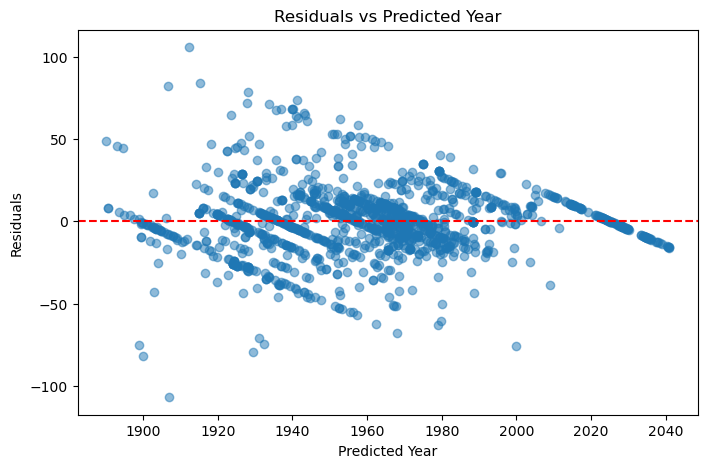

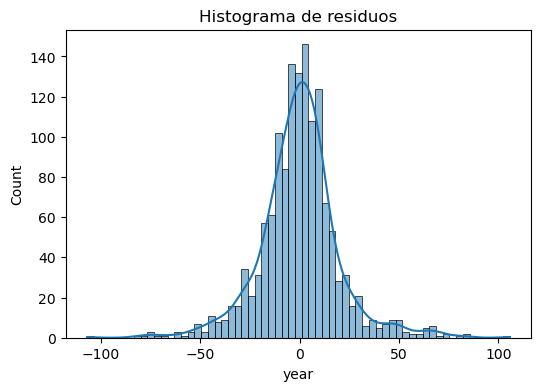

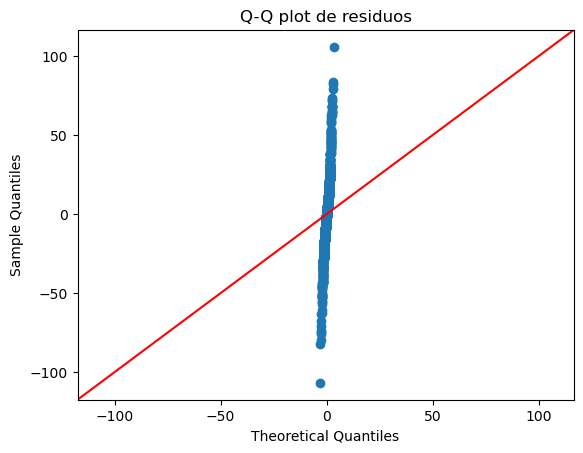

Media de residuos: 5.3328580594361464e-14
Desviación estándar de residuos: 20.276606774143186


NameError: name 'r2_score' is not defined

In [288]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# Librerías necesarias

import matplotlib.pyplot as plt


# ---------------------------
# 1️⃣ Preparar los datos
# ---------------------------
# Supongamos que tu dataframe se llama `data`
# Eliminamos columnas innecesarias
data_clean = data.drop(columns=['url', 'agency','description','floor','exterior', 'heating','usable_area','consumption_label','emissions_label','consumption_value','emissions_value'])

# Convertir columnas binarias a 0/1
binary_cols = ['elevator', 'garage', 'storage_room', 'balcony', 'new']
for col in binary_cols:
    data_clean[col] = data_clean[col].map({True: 1, False: 0, 'True': 1, 'False': 0, 'Nuevo': 1, 'Buen estado': 0})

# Para 'condition', si hay más de 2 categorías, lo convertimos a One-Hot
# Si solo dos categorías (Nuevo/Buen estado) ya lo manejamos arriba

# Columnas categóricas con múltiples categorías
categorical_cols = ['zone', 'neighborhood', 'condition']
data_encoded = pd.get_dummies(data_clean, columns=categorical_cols, drop_first=True)


print(data_encoded.head())

# Eliminar filas con NA
data_encoded = data_encoded.dropna()


# Separar variables dependiente e independiente
X = data_encoded.drop(columns=['year'])
y = data_encoded['year']




# ---------------------------
# 2️⃣ Ajustar Linear Regression
# ---------------------------
model = LinearRegression()
model.fit(X, y)

# ---------------------------
# 3️⃣ Predicciones y residuos
# ---------------------------
y_pred = model.predict(X)
residuals = y - y_pred

# ---------------------------
# 4️⃣ Graficar residuos
# ---------------------------
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Year")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Year")
plt.show()

# Histograma de residuos
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Histograma de residuos")
plt.show()

# Q-Q plot para revisar normalidad
sm.qqplot(residuals, line='45')
plt.title("Q-Q plot de residuos")
plt.show()

# ---------------------------
# 5️⃣ Resumen estadístico de residuos
# ---------------------------
print("Media de residuos:", residuals.mean())
print("Desviación estándar de residuos:", residuals.std())




r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("R²:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

REGRESSION PRUEBA 2.0

Coeficientes Lasso:
 price                                                    0.000000
built_area                                              -0.000000
bedrooms                                                -1.390247
bathrooms                                                0.000000
elevator                                                 1.088200
garage                                                   6.161037
storage_room                                             2.803541
balcony                                                 -1.373965
new                                                     12.083507
zone_basurto-zorroza                                     2.508580
zone_begona-santutxu                                     3.771307
zone_casco-viejo                                        -8.917751
zone_deusto                                              7.660494
zone_ibaiondo                                           -5.912866
zone_indautxu                                          

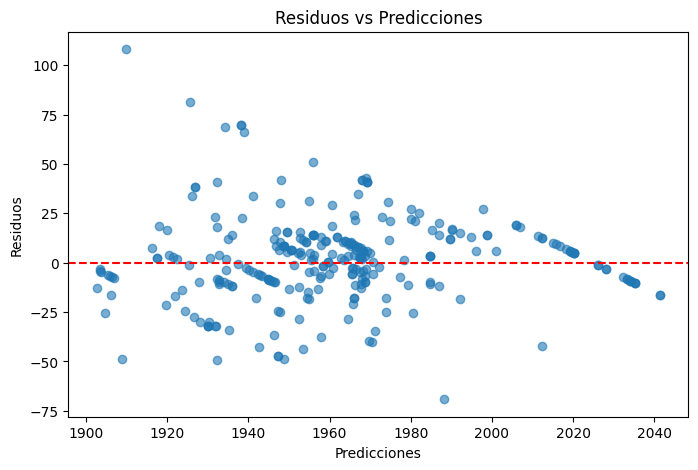

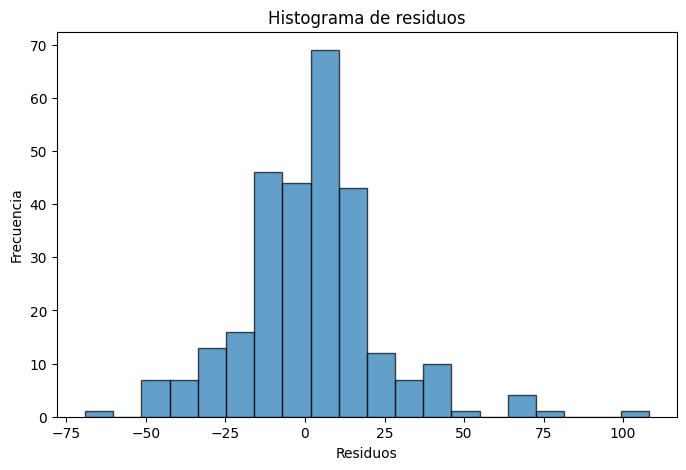

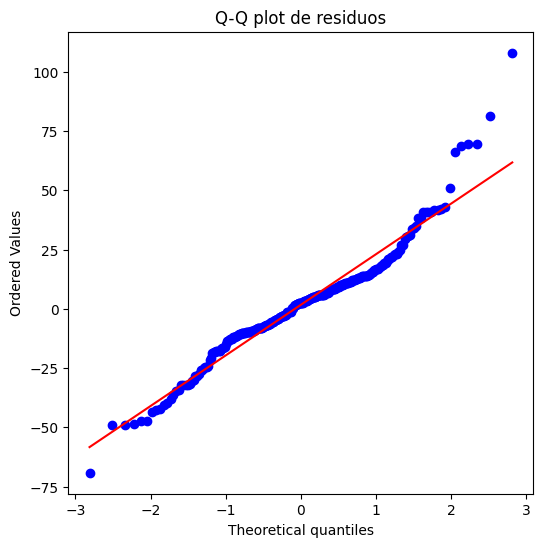

In [ ]:
#Regresion prueba 2




import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import root_mean_squared_error, r2_score
import scipy.stats as stats

# ---------------------------
# 1️⃣ Preparar los datos
# ---------------------------
# Supongamos que tu dataframe se llama `data`
# Eliminamos columnas innecesarias
data_clean = data.drop(columns=['url', 'agency','description','floor','exterior', 'heating','usable_area','consumption_label','emissions_label','consumption_value','emissions_value'])

# Convertir columnas binarias a 0/1
binary_cols = ['elevator', 'garage', 'storage_room', 'balcony', 'new']
for col in binary_cols:
    data_clean[col] = data_clean[col].map({True: 1, False: 0, 'True': 1, 'False': 0, 'Nuevo': 1, 'Buen estado': 0})

# Para 'condition', si hay más de 2 categorías, lo convertimos a One-Hot
# Si solo dos categorías (Nuevo/Buen estado) ya lo manejamos arriba

# Columnas categóricas con múltiples categorías
categorical_cols = ['zone', 'neighborhood', 'condition']
data_encoded = pd.get_dummies(data_clean, columns=categorical_cols, drop_first=True)



# Eliminar filas con NA
data_encoded = data_encoded.dropna()


# Separar variables dependiente e independiente
X = data_encoded.drop(columns=['year'])
y = data_encoded['year']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Ajustar el scaler solo con X_train
X_train_scaled = scaler.fit_transform(X_train)

# Transformar X_test usando el mismo scaler (no hacer fit otra vez)
X_test_scaled = scaler.transform(X_test)
# Lasso con cross-validation para elegir el alpha óptimo
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)


# Coeficientes
coef = pd.Series(lasso.coef_, index=X.columns)
print("Coeficientes Lasso:\n", coef)

# Features seleccionadas
selected_features = coef[coef != 0].index.tolist()
print("Features seleccionadas:", selected_features)


# Predicciones en el set de test
y_pred = lasso.predict(X_test_scaled)

# Métricas
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#RMSE = 21.87 lo que significa que, en promedio, las predicciones del modelo se desvían del valor real de "year" en aproximadamente 21.87 años.
print(f"RMSE: {rmse:.2f}")

#R² = 0.66 lo que indica que el modelo explica aproximadamente el 66% de la variabilidad en la variable dependiente "year".
print(f"R²: {r2:.2f}")


residuals = y_test - y_pred

# a) Residual plot (linealidad y homocedasticidad) --> OJJOJ: se aprecia cierta heterocedasticidad
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones")
plt.show()

# b) Histograma de residuos (normalidad) --> bien porque los residuos siguen mas o menos una distribucion normal
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos")
plt.show()

# c) Q-Q plot de residuos (normalidad) --> OJOJO: mas o menos normal pero en la cola derecha se aleja bastante de la linea
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q plot de residuos")
plt.show()



Ahora probaremos con polynomial regression

### Consumption label cleaning

In [290]:
# PREPARING THE DATA
data_consumption = data.copy()
print(data_consumption.info())
data_consumption.drop(columns=["consumption_value", "emissions_value", "emissions_label", "url", "description"], inplace=True)

data_consumption = data_consumption.dropna(subset=["consumption_label"])

# FIRST SUBSET: drop rows with any null value
data_consumption_subset1 = data_consumption.dropna(axis=0)

X_consumption_1 = data_consumption_subset1.drop(columns=["consumption_label"])
y_consumption_1 = data_consumption_subset1["consumption_label"]

# SECOND SUBSET:
data_consumption_subset2 = data_consumption.copy()

for col in ["usable_area", "floor", "year"]:
    data_consumption_subset2[col] = data_consumption[col].fillna(data_consumption[col].median())

for col in ["exterior", "heating", "condition"]:
    data_consumption_subset2[col] = data_consumption[col].fillna(data_consumption[col].mode()[0])

X_consumption_2 = data_consumption_subset2.drop(columns=["consumption_label"])
y_consumption_2 = data_consumption_subset2["consumption_label"]

print(X_consumption_2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1407 entries, 0 to 1489
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   url                1407 non-null   object  
 1   price              1407 non-null   float64 
 2   zone               1407 non-null   category
 3   neighborhood       1407 non-null   category
 4   built_area         1407 non-null   float64 
 5   usable_area        962 non-null    float64 
 6   bedrooms           1407 non-null   int32   
 7   bathrooms          1407 non-null   int32   
 8   floor              1265 non-null   float64 
 9   exterior           1244 non-null   object  
 10  elevator           1407 non-null   bool    
 11  garage             1407 non-null   bool    
 12  storage_room       1407 non-null   bool    
 13  balcony            1407 non-null   bool    
 14  new                1407 non-null   bool    
 15  condition          1407 non-null   object  
 16  year       

In [291]:
# IMPLEMENTING THE MODEL
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

cat_cols = ["zone", "neighborhood", "exterior", "condition", "heating", "agency"]

# FIRST SUBSET
X_consumption_1encoded = df = pd.get_dummies(X_consumption_1, columns=cat_cols, drop_first=True)
y_consumption_1encoded = LabelEncoder().fit_transform(y_consumption_1)

model = RandomForestClassifier()
accs = cross_val_score(model, X_consumption_1encoded, y_consumption_1encoded, cv=5) #KFold(n_splits=5, shuffle=True, random_state=5

print("Average accuracy FIRST SUBSET:", sum(accs)/len(accs))

# SECOND SUBSET
X_consumption_2encoded = df = pd.get_dummies(X_consumption_2, columns=cat_cols, drop_first=True)
y_consumption_2encoded = LabelEncoder().fit_transform(y_consumption_2)

X_train, X_test, y_train, y_test = train_test_split(X_consumption_2encoded, y_consumption_2encoded, test_size=0.2, stratify=y_consumption_2encoded, random_state=42)

rf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

print("Average accuracy SECOND SUBSET:", accuracy_score(y_test, rf.predict(X_test)))

accs = cross_val_score(model, X_consumption_2encoded, y_consumption_2encoded, cv=5) #KFold(n_splits=5, shuffle=True, random_state=5

print("Average accuracy SECOND SUBSET (K-FOLDS):", sum(accs)/len(accs))

c:\Users\xabier.villa\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Average accuracy FIRST SUBSET: 0.6536082474226804
Average accuracy SECOND SUBSET: 0.7486910994764397
Average accuracy SECOND SUBSET (K-FOLDS): 0.58496555524938


## STORE

##  EXTERIOR (Gonzalo)

In [ ]:

data.columns


Index(['url', 'price', 'zone', 'neighborhood', 'built_area', 'usable_area',
       'bedrooms', 'bathrooms', 'floor', 'exterior', 'elevator', 'garage',
       'storage_room', 'balcony', 'new', 'condition', 'year', 'heating',
       'agency', 'consumption_value', 'consumption_label', 'emissions_value',
       'emissions_label', 'description'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm
# Miramos si en la columna de descrippcion esta la palabra exterior (si tiene la palabra terraza o balcon lo incluimos tambien) 

print(data["exterior"].isnull().sum())
condicion_esnula = data["exterior"].isnull()
condicion_contiene_palabra = data["description"].str.contains("exterior|terraza|balcon", case=False, na=False)
data.loc[condicion_contiene_palabra & condicion_esnula, "exterior"] = "exterior"
print(data["exterior"].isnull().sum())

print(data["exterior"].isnull().sum())
condicion_esnula = data["exterior"].isnull()
condicion_contiene_palabra = data["description"].str.contains("interior|sin terraza|sin balcon|luz indirecta", case=False, na=False)
data.loc[condicion_contiene_palabra & condicion_esnula, "exterior"] = "exterior"
print(data["exterior"].isnull().sum())



#A partir de agosto del 22 todas las casas nuevas deben de ser exteriores -> hacemos que a partir del 2023 incluido si es nulo se pone exterior (esto creo que bien)
print(data["exterior"].isnull().sum())
condicion_año = data["year"] >= 2023
data.loc[condicion_esnula & condicion_año, "exterior"] = "exterior"
print(data["exterior"].isnull().sum())


#En este caso no nos ha servido ya que con el de arriba hemos cubieto a la segunda pero lo mantenemos por si en un futuro se actualiza



163
61
61
55
55
55


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Separar filas con etiqueta y las que hay que predecir
train_val_data = data.dropna(subset=["exterior"]).copy() 
train_val_data["target"] = train_val_data["exterior"].apply(lambda x: 1 if x == "exterior" else 0)
predict_data = data[data["exterior"].isna()].copy()

# Definir características
num_features  = ["price", "built_area", "usable_area", "bedrooms", "bathrooms", "floor", "year"]
bool_features = ["elevator", "garage", "storage_room", "balcony"]
cat_features  = ["new", "condition", "heating", "consumption_label", "emissions_label"]

features = num_features + bool_features + cat_features

# Convertir booleanos a 1/0
for b in bool_features:
    if b in train_val_data.columns:
        train_val_data[b] = train_val_data[b].map({True:1, False:0, "True":1, "False":0}).fillna(0).astype(int)
        if b in predict_data.columns:
            predict_data[b] = predict_data[b].map({True:1, False:0, "True":1, "False":0}).fillna(0).astype(int)


# Separar features y target
X = train_val_data[features]
y = train_val_data["target"]

# Split train/val estratificado
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y #el 42 es como la seed de r studio para que en todas las runs sea igual
)

# Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) 
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, [c for c in num_features if c in features]),
    ("bool", "passthrough", [c for c in bool_features if c in features]),
    ("cat", categorical_transformer, [c for c in cat_features if c in features])
])


# Pipeline Random Forest 
rf = RandomForestClassifier(random_state=1, class_weight={0: 6, 1: 1})  # da más importancia a interiores
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf)
])

# GridSearch de hiperparámetros: Busca la mejor convinacion de hiperparametros
param_grid = {
    "classifier__n_estimators": [200, 300],
    "classifier__max_depth": [10, 15, None],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1,2, 3, 4]
}

min_class_count = y.value_counts().min()
n_splits = 4 if min_class_count >= 4 else max(2, min_class_count)
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Entrenar modelo
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV F1:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Evaluar en Validation
y_val_pred = best_model.predict(X_val)
print("=== Validation Results ===")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Cross-validation extra
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
print("\nCross-validation F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

# Predecir filas con exterior NaN 

if not predict_data.empty:
    X_predict = predict_data[features]
    preds = best_model.predict(X_predict)
    
    # Crear columnas de predicción
    predict_data = predict_data.copy()
    predict_data["target_pred"] = preds
    predict_data["exterior_pred"] = predict_data["target_pred"].apply(lambda x: "exterior" if x == 1 else "interior")
    
    # Mostrar ejemplos de predicción (primeras 10 filas)
    print("Ejemplos de predicción:")
    print(predict_data[["url", "exterior_pred"]].to_string(index=False))
    
    # Mostrar conteo de predicciones
    print("Conteo de predicciones:")
    print(predict_data["exterior_pred"].value_counts())



Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best parameters: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best CV F1: 0.9548623944457278
=== Validation Results ===
              precision    recall  f1-score   support

           0       0.88      0.59      0.71        37
           1       0.94      0.99      0.96       234

    accuracy                           0.93       271
   macro avg       0.91      0.79      0.84       271
weighted avg       0.93      0.93      0.93       271

Confusion Matrix:
 [[ 22  15]
 [  3 231]]

Cross-validation F1 scores: [0.95061728 0.95       0.96049896 0.95833333]
Mean CV F1: 0.9548623944457278
Ejemplos de predicción:
                                          url exterior_pred
https://www.idealista.com/inmueble/108574469/      exterior
https://www.idealista.com/inmueble/107910726/      exterior
https://www.idealista.com/inmueble/108520857/     

### Floor:

In [294]:
print(data.columns)
dataPrueba =data.copy()
print(dataPrueba["floor"].isnull().sum())
#print(dataPrueba[dataPrueba["floor"].isnull()][["floor","url"]])

key_words = {# revisar si entreplanta la contamos como 0
    'sotano': -2, 'semisótano': -2, 'semisotano': -2,'sótano': -2,
    'casa': -1, 'chalet': -1, 'adosado': -1,
    'bajo': 0, 'planta baja': 0,'entreplanta': 0,'piso 0': 0,'planta 0': 0,
    'primera planta': 1, 'primer piso': 1, 'piso 1': 1,'planta 1': 1,
    'segunda planta': 2, 'segundo piso': 2,'Piso 2': 2,'planta 2': 2,
    'tercera planta': 3, 'tercer piso': 3,'piso 3': 3,'planta 3': 3,
    'cuarta planta': 4, 'cuarto piso': 4,'piso 4': 4,'planta 4': 4,
    'quinta planta': 5, 'quinto piso': 5,'piso 5': 5,'planta 5': 5,
    'sexta planta': 6, 'sexto piso': 6,'piso 6': 6,'planta 6': 6,
    'séptima planta': 7, 'séptimo piso': 7,'piso 7': 7,'planta 7': 7,
    'octava planta': 8, 'octavo piso': 8,'piso 8': 8,'planta 8': 8,
    'novena planta': 9, 'noveno piso': 9,'piso 9': 9,'planta 9': 9,
    'décima planta': 10, 'décimo piso': 10,'piso 10': 10,'planta 10': 10
}

for index, row in dataPrueba[dataPrueba["floor"].isnull()].iterrows():
    if any(kw in dataPrueba.loc[index, 'description'].lower() for kw in key_words.keys()):
        for kw, floor_value in key_words.items():
            if kw in dataPrueba.loc[index, 'description'].lower():
                dataPrueba.loc[index, 'floor'] = floor_value
                print(f"encontramos {kw}")
                print(dataPrueba.loc[index, 'url'])
                break


print(dataPrueba["floor"].isnull().sum())
#print(dataPrueba[dataPrueba["floor"].isnull()][["floor","url"]])

#hecho a mano

manual_floors = {
    10: 0,    14: np.nan,    15: 6,    16: 1,
    36: 2,    37: 2,    38: 1,    39: 4,
    56: 2,    59: 7,    60: 7,    66: 6,
    83: 0,    84: np.nan,    196: np.nan,    214: 0,
    227: np.nan,    254: -1,    258: -1,    261: np.nan,
    266: np.nan,    267: np.nan,    268: 0,    316: 0,
    324: 0,    352: np.nan,    368: np.nan,    393: 0,
    398: 0,    452: np.nan,    466: np.nan,    478: np.nan,
    659: 0,    686: np.nan,    738: 0,    742: 0,
    743: 0,    752: 0,    768: 0,    804: 0,        
    950: 1,    951: 14,    953: np.nan,    976: 13,
    977: 20,    978: 13,    992: np.nan,    1001: 0,
    1016: 0,    1030: 0,    1031: 0,    1083: np.nan,
    1090: 0,    1093: 0,    1101: np.nan,    1113: 4,
    1114: 2,    1115: 1,    1116: 2,    1117: 1,
    1118: 4,    1119: 2,    1120: 5,    1121: 5,
    1122: 2,    1123: 2,    1124: 7,    1125: 4,
    1153: np.nan,    1158: 0,    1202: 0,    1203: np.nan,
    1213: np.nan,    1214: np.nan,    1233: 0,    1314: 0,
    1342: np.nan,    1355: np.nan,    1385: np.nan,    1404: 0,
    1414: np.nan,    1431: np.nan,    1433: np.nan,    1438: np.nan,
    1486: 0
}

for idx, val in manual_floors.items():
    dataPrueba.loc[idx, 'floor'] = val


print(dataPrueba["floor"].isnull().sum())


Index(['url', 'price', 'zone', 'neighborhood', 'built_area', 'usable_area',
       'bedrooms', 'bathrooms', 'floor', 'exterior', 'elevator', 'garage',
       'storage_room', 'balcony', 'new', 'condition', 'year', 'heating',
       'agency', 'consumption_value', 'consumption_label', 'emissions_value',
       'emissions_label', 'description'],
      dtype='object')
142
encontramos piso 3
https://www.idealista.com/inmueble/109237730/
encontramos casa
https://www.idealista.com/inmueble/108746339/
encontramos casa
https://www.idealista.com/inmueble/108396564/
encontramos casa
https://www.idealista.com/inmueble/107910726/
encontramos casa
https://www.idealista.com/inmueble/108492917/
encontramos entreplanta
https://www.idealista.com/inmueble/108519774/
encontramos chalet
https://www.idealista.com/inmueble/83189354/
encontramos casa
https://www.idealista.com/inmueble/107023759/
encontramos chalet
https://www.idealista.com/inmueble/108421719/
encontramos chalet
https://www.idealista.com/inmueb

###  Consumption/emision values: (Xabi)

seeing that there is a lot of information missing in the values, we are going to do a study of the values ​​we have, to see in what ranges the labels are in each house in order to assign a label to each one.

In [ ]:
print(data['emissions_label'].isnull().sum())
print(data['emissions_value'].isnull().sum())


dataWithValues = data['emissions_label'].notnull() & data['emissions_value'].notnull()

print(data[dataWithValues]["emissions_label"].value_counts())

486
690
emissions_label
E    453
F    105
G     86
D     51
C     13
A      8
B      1
Name: count, dtype: int64
